<a href="https://colab.research.google.com/github/dimou-gk/Cost-Optimized-Refueling-for-Fixed-Route-Fleets/blob/main/4_Fuel_Consumption_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
import itertools
!pip install pulp
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus, value, LpContinuous

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 38.7 MB/s eta 0:00:00


# PlanHelper

In [2]:
class Plan:
    def __init__(self,model,feature_names,target_name,filename="test_set.csv"):
        """
        This class will generate trip plans based on the test data after the trip segmentation.

        @param model: The model you trained
        @param feature_names: The features you used to train the model
        @param target_name: The target you used to train the model
        @param filename: The file name of the test set.
        """
        self.df = pd.read_csv(filename)
        self.plan_dict,self.stations=self.make_plan(longshort=80, Fuel_stations=10, random_int_trips=10)
        self.model=model
        self.feature_names=feature_names
        self.target_name=target_name
    def make_plan(self,longshort=80,Fuel_stations=10,random_int_trips=10,initmax=100):

        startposition = 0
        dflong=self.df[self.df["distance_travelled"]>longshort]
        dfshort=self.df[self.df["distance_travelled"]<longshort]

        plan=[]

        plan_dict= {}

        short_id=np.argmax(dfshort["distance_travelled"].values)
        first=dfshort.iloc[short_id]
        dfshort = dfshort.drop(dfshort.index[short_id])

        short_id2=random.randint(0, dfshort.shape[0] - 1)
        plan.append((first, dfshort.iloc[short_id2]))
        dfshort = dfshort.drop(dfshort.index[short_id2])


        for i in range(min([dfshort.shape[0],dflong.shape[0],Fuel_stations])):

            long_id=random.randint(0,dflong.shape[0]-1)

            short_id = random.randint(0, dfshort.shape[0] - 1)

            plan.append((dflong.iloc[long_id],dfshort.iloc[short_id]))
            dflong=dflong.drop(dflong.index[long_id])
            dfshort=dfshort.drop(dfshort.index[short_id])

        remaining=[]
        for i in range(dflong.shape[0]):
            remaining.append(dflong.iloc[i])
        for i in range(dfshort.shape[0]):
            remaining.append(dfshort.iloc[i])
        random.shuffle(remaining)

        #Changed this line
        for i in range(random_int_trips, len(remaining)):
            position=random.randint(0,len(plan)-1)
            plan=plan[:position]+[(remaining[i],None)]+plan[position:]

        stations= {}
        for pln in plan:
            startposition+= pln[0]["distance_travelled"]
            plan_dict[startposition]=pln
            if pln[1] is not None:
                stations[startposition]=pln[1]
        return plan_dict,stations

    def get_main_road_trips(self,from_km,to_km):
        trips = []
        shorted_keys = sorted(self.plan_dict.keys())
        for i in range(len(shorted_keys)):
            if shorted_keys[i] > from_km and shorted_keys[i] <= to_km:
                trips.append(self.plan_dict[shorted_keys[i]][0])
        return trips
    def get_extra_to_station_trip(self,km):
        if km in self.stations.keys():
            return self.stations[km]
        else:
            return None
    def stations_km(self):
        return_stations=[]
        for key in self.stations.keys():
            return_stations.append(key)
        return_stations.sort()
        return return_stations



    def predict(self, trips):
        estimations = []
        for trip in trips:
            x = trip[self.feature_names]
            # print(x.values)
            estimation = self.model.predict(np.array([x.values]))
            estimations.append(estimation[0])
        return estimations

    def real_consumption(self,trips):
        estimations = []
        for trip in trips:
            estimations.append(trip[self.target_name])
        return estimations
    def real_Consumption_form_to(self, from_km, to_km):
        """
        This function will return the REAL consumption from Kilometer 'from_km' until 'to_km'
        Note that this not include the consumption for reaching station.
        """
        trips = self.get_main_road_trips(from_km, to_km)
        return sum(self.real_consumption(trips))
    def Consumption_form_to(self, from_km, to_km):
        """
        This function will return the estimation of consumption from Kilometer 'from_km' until 'to_km'
        Note that this not include the consumption for reaching station.
        """
        trips = self.get_main_road_trips(from_km, to_km)
        return sum(self.predict(trips))

    def Extra_consumption_to_reach_station(self, km):
        """
        This function will return the estimation of consumption of the EXTRA distance to reach a Fuel station from kilometer km
        """
        trips = [self.get_extra_to_station_trip(km)]
        return sum(self.predict(trips))
    def Extra_real_consumption_to_reach_station(self, km):
        """
        This function will return the REAL consumption of the EXTRA distance to reach a Fuel station from kilometer km
        """
        trips = [self.get_extra_to_station_trip(km)]
        return sum(self.real_consumption(trips))


def train_model(features, target, model):
    feature_names = features
    target_name = target
    final_result=pd.read_csv("train_test_set.csv")
    train_set = final_result[final_result["split"] == "train"]
    intX=train_set[feature_names+[target_name]].replace([np.inf, -np.inf], np.nan).dropna()
    X = intX[feature_names].values
    y1 = intX[target_name]
    model = model
    model.fit(X, y1)

    return model

# Setup

In [3]:
#Hardcoded model from previous notebook
model = Lasso(alpha= 0.1)
df_test = pd.read_csv("test_data.csv")
feature_names = df_test.drop(columns=['lit_per_100km']).columns.to_list()
target_name = 'lit_per_100km'
filename = "test_data.csv"

ConsumptionModel=train_model(feature_names, target_name, model)

plan = Plan(model, feature_names, target_name, filename)

station_points=plan.stations_km()
print(f"Positions of Stations: {station_points}")

Positions of Stations: [np.float64(73.7), np.float64(408.65), np.float64(572.52), np.float64(674.24), np.float64(926.475), np.float64(1468.935)]


# Approaches

Try 3 different methods. Greedy and Cartessian which are not Optimization methods but take a greedy path and follow it to the end and compare all possible results using Cartessian product and select the best. Finally we employ a strategy using Multi-Objective Optimization

## Greedy Approach - Consider only one Plan

In [4]:
def find_greedy_plan(plan: Plan, max_fuel: float = 300, start_fuel: float = 150, use_real: bool = False):
    """
    Greedy strategy: refuel only when the next station cannot be reached.

    Parameters:
    - plan: Plan instance
    - max_fuel: max tank capacity
    - start_fuel: initial fuel at start
    - use_real: use real consumption if True, else use predicted

    Returns:
    - selected_stations: list of station km positions where we stop to refuel
    - log: list of tuples (from_km, to_km, fuel_used)
    - ran_out: True if we would run out of fuel, False otherwise
    """
    stations = plan.stations_km()
    selected_stations = []
    log = []
    fuel = start_fuel
    current_km = 0
    ran_out = False

    # Choose the appropriate method
    consumption_fn = plan.real_Consumption_form_to if use_real else plan.Consumption_form_to
    extra_fn = plan.Extra_real_consumption_to_reach_station if use_real else plan.Extra_consumption_to_reach_station

    for i, station_km in enumerate(stations):
        fuel_needed = consumption_fn(current_km, station_km) + extra_fn(station_km)

        if fuel_needed > fuel:
            # Can't reach this station, refuel at previous
            if not selected_stations and i == 0:
                print("Cannot reach the first station!")
                ran_out = True
                break
            prev_station = stations[i - 1]
            selected_stations.append(prev_station)
            current_km = prev_station
            fuel = max_fuel
            fuel_needed = consumption_fn(current_km, station_km) + extra_fn(station_km)

            if fuel_needed > fuel:
                print(f"Still can't reach station at km {station_km} after refueling at km {prev_station}.")
                ran_out = True
                break
        fuel -= fuel_needed
        log.append((current_km, station_km, fuel_needed))
        current_km = station_km

    return selected_stations, log, ran_out

In [5]:
def evaluate_plan(plan: Plan):
    model_plan, model_log, model_fail = find_greedy_plan(plan, use_real=False)
    real_plan, real_log, real_fail = find_greedy_plan(plan, use_real=True)

    print("\n=== MODEL PLAN ===")
    print("Stops at stations:", model_plan)
    print("Fuel log (from_km, to_km, used):")
    for leg in model_log:
        print(leg)
    print("Ran out of fuel (model)?", model_fail)

    print("\n=== ACTUAL PLAN ===")
    print("Stops at stations:", real_plan)
    print("Fuel log (from_km, to_km, used):")
    for leg in real_log:
        print(leg)
    print("Ran out of fuel (actual)?", real_fail)

    print("\n=== COMPARISON ===")
    if model_plan == real_plan:
        print("The model and real plans choose the same stations.")
    else:
        print("The model and real plans differ.")
    if model_fail:
        print("The model's plan would leave the vehicle stranded!")

In [6]:
evaluate_plan(plan)


=== MODEL PLAN ===
Stops at stations: [np.float64(408.65)]
Fuel log (from_km, to_km, used):
(0, np.float64(73.7), np.float64(61.713045601034615))
(np.float64(73.7), np.float64(408.65), np.float64(73.18667419375535))
(np.float64(408.65), np.float64(572.52), np.float64(65.61124746623616))
(np.float64(572.52), np.float64(674.24), np.float64(76.14899159291977))
(np.float64(674.24), np.float64(926.475), np.float64(66.83639076814595))
(np.float64(926.475), np.float64(1468.935), np.float64(64.15867605085998))
Ran out of fuel (model)? False

=== ACTUAL PLAN ===
Stops at stations: [np.float64(408.65)]
Fuel log (from_km, to_km, used):
(0, np.float64(73.7), np.float64(62.00900666))
(np.float64(73.7), np.float64(408.65), np.float64(65.08294323))
(np.float64(408.65), np.float64(572.52), np.float64(59.12015269))
(np.float64(572.52), np.float64(674.24), np.float64(84.49194390000001))
(np.float64(674.24), np.float64(926.475), np.float64(42.11696546100001))
(np.float64(926.475), np.float64(1468.935), 

In [7]:
def plot_fuel_comparison(plan: Plan):
    model_plan, model_log, model_fail = find_greedy_plan(plan, use_real=False)
    real_plan, real_log, real_fail = find_greedy_plan(plan, use_real=True)

    # Prepare data
    model_segments = [f"{start}-{end}" for (start, end, _) in model_log]
    model_fuel = [used for (_, _, used) in model_log]

    real_segments = [f"{start}-{end}" for (start, end, _) in real_log]
    real_fuel = [used for (_, _, used) in real_log]

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35
    x = range(len(model_segments))

    ax.bar(x, model_fuel, width=width, label='Predicted Consumption', color='skyblue')
    ax.bar([i + width for i in x], real_fuel, width=width, label='Actual Consumption', color='orange')

    # Add x-axis labels and rotate
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(model_segments, rotation=45)
    ax.set_ylabel('Fuel Consumption (liters)')
    ax.set_title('Fuel Consumption Per Trip Segment')
    ax.legend()

    # Annotate warnings
    if model_fail:
        plt.figtext(0.5, 0.01, "WARNING: Model plan could result in running out of fuel!", ha='center', color='red', fontsize=12)
    elif real_fail:
        plt.figtext(0.5, 0.01, "WARNING: Real consumption would lead to fuel shortage!", ha='center', color='darkorange', fontsize=12)
    else:
        plt.figtext(0.5, 0.01, "Safe: Both model and actual plans avoid fuel depletion.", ha='center', color='green', fontsize=12)

    plt.tight_layout()
    plt.show()

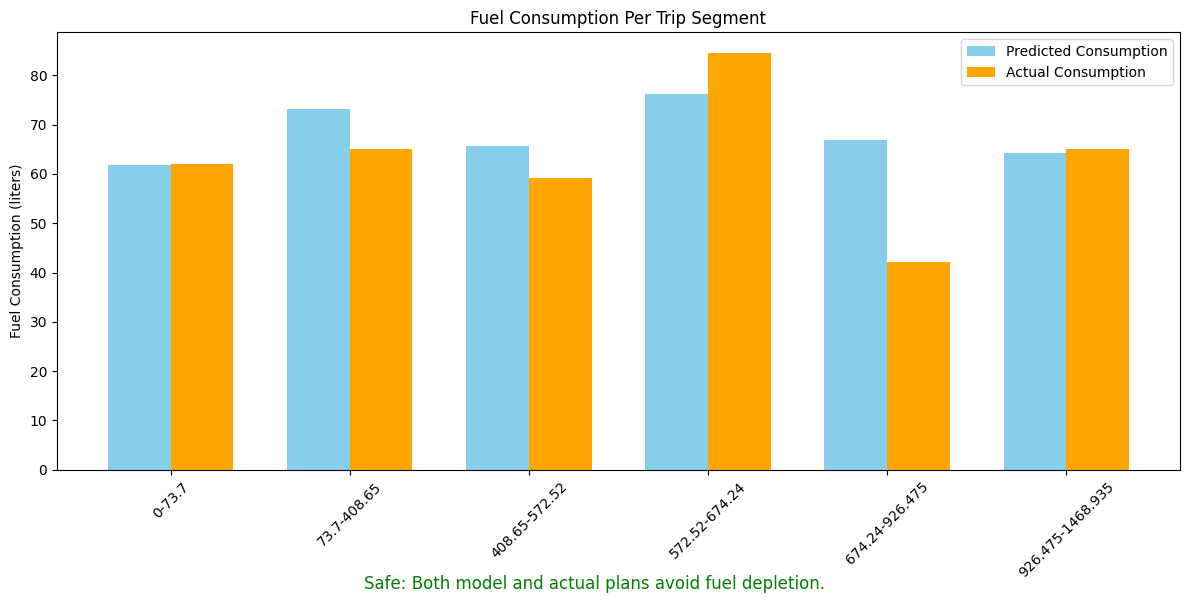

In [8]:
plot_fuel_comparison(plan)

## Cartessian Plan Search - Search all available Plans

In [9]:
def find_optimal_plan(plan, Fuel_Tank_Start = 150, Tank_Limit = 300):
    station_points = plan.stations_km()
    FuelTankStart = Fuel_Tank_Start
    TankLimit = Tank_Limit
    best_plan = None
    min_consumption = float('inf')

    # Try all combinations of refueling stations (including none)
    for r in range(len(station_points) + 1):
        for refuel_stations in itertools.combinations(station_points, r):
            FuelTank = FuelTankStart
            FuelSpent = 0
            current_km = 0
            success = True

            for stop_km in list(refuel_stations) + [station_points[-1]]:  # Always end at the last station
                try:
                    # Estimate consumption to get from current_km to stop_km
                    trip_consumption = plan.Consumption_form_to(current_km, stop_km)
                    extra_consumption = 0
                    if stop_km in refuel_stations:
                        extra_consumption = plan.Extra_consumption_to_reach_station(stop_km)

                    total_segment_consumption = trip_consumption + extra_consumption

                    if FuelTank < total_segment_consumption:
                        success = False
                        break  # This plan doesn't work

                    # Deduct fuel
                    FuelTank -= total_segment_consumption
                    FuelSpent += total_segment_consumption
                    current_km = stop_km

                    # Refuel if this stop is a refueling station
                    if stop_km in refuel_stations:
                        FuelTank = TankLimit  # Refill tank
                except:
                    success = False
                    break

            if success and FuelSpent < min_consumption:
                min_consumption = FuelSpent
                best_plan = list(refuel_stations)

    print(f"Optimal plan: stop at stations {best_plan}")
    print(f"Estimated total fuel consumption: {min_consumption:.2f}")
    return best_plan

In [10]:
def print_plan_summary(plan, refuel_stations, Fuel_Tank_Start = 150, Tank_Limit = 300):
    station_points = plan.stations_km()
    FuelTank = Fuel_Tank_Start
    TankLimit = Tank_Limit
    current_km = 0
    total_fuel = 0.0

    print("\n JOURNEY SUMMARY")
    print("-" * 40)
    for stop_km in list(refuel_stations) + [station_points[-1]]:
        trip = plan.Consumption_form_to(current_km, stop_km)
        extra = plan.Extra_consumption_to_reach_station(stop_km) if stop_km in refuel_stations else 0
        total_segment = trip + extra

        print(f" From {current_km:.1f} km to {stop_km:.1f} km")
        print(f"   Trip Consumption: {trip:.2f} L")
        if extra > 0:
            print(f"   Detour to Refuel: +{extra:.2f} L")
        print(f"   Total Segment: {total_segment:.2f} L")

        FuelTank -= total_segment
        if FuelTank < 0:
            print("Not enough fuel — INVALID PLAN!")
            return

        total_fuel += total_segment
        current_km = stop_km

        if stop_km in refuel_stations:
            print(f"Refueled to {TankLimit} L")
            FuelTank = TankLimit

        print(f"Fuel Remaining: {FuelTank:.2f} L")
        print("-" * 40)

    print(f"\nTotal Estimated Fuel Consumption: {total_fuel:.2f} L")
    print(f"Final Fuel Left in Tank: {FuelTank:.2f} L")

In [11]:
def plot_fuel_profile(plan, refuel_stations):
    station_points = plan.stations_km()
    FuelTank = 150
    TankLimit = 300
    current_km = 0
    fuel_levels = [FuelTank]
    kms = [0]

    for stop_km in list(refuel_stations) + [station_points[-1]]:
        trip = plan.Consumption_form_to(current_km, stop_km)
        extra = plan.Extra_consumption_to_reach_station(stop_km) if stop_km in refuel_stations else 0
        consumption = trip + extra

        FuelTank -= consumption
        current_km = stop_km
        kms.append(current_km)
        fuel_levels.append(FuelTank)

        if stop_km in refuel_stations:
            FuelTank = TankLimit
            kms.append(current_km)
            fuel_levels.append(FuelTank)

    plt.figure(figsize=(12, 6))
    plt.plot(kms, fuel_levels, marker='o', label='Fuel Level')
    for s in station_points:
        plt.axvline(x=s, color='gray', linestyle='--', alpha=0.3)
    for r in refuel_stations:
        plt.axvline(x=r, color='green', linestyle='-', label='Refuel' if r == refuel_stations[0] else "")

    plt.title("Truck Fuel Level Over Journey")
    plt.xlabel("Distance (km)")
    plt.ylabel("Fuel in Tank (L)")
    plt.legend()
    plt.grid(True)
    plt.show()

Optimal plan: stop at stations [np.float64(572.52)]
Estimated total fuel consumption: 225.57

 JOURNEY SUMMARY
----------------------------------------
 From 0.0 km to 572.5 km
   Trip Consumption: 105.16 L
   Detour to Refuel: +26.26 L
   Total Segment: 131.42 L
Refueled to 300 L
Fuel Remaining: 300.00 L
----------------------------------------
 From 572.5 km to 1468.9 km
   Trip Consumption: 94.15 L
   Total Segment: 94.15 L
Fuel Remaining: 205.85 L
----------------------------------------

Total Estimated Fuel Consumption: 225.57 L
Final Fuel Left in Tank: 205.85 L


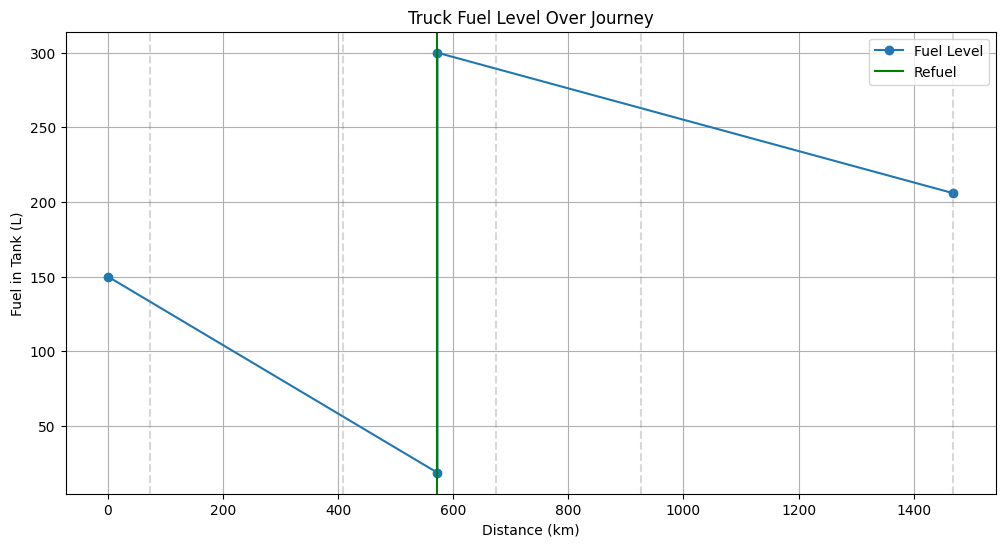

In [12]:
optimal_plan = find_optimal_plan(plan)
print_plan_summary(plan, optimal_plan)
plot_fuel_profile(plan, optimal_plan)

In [13]:
def simulate_all_detailed_plans(plan, max_stops=3):
    stations = plan.stations_km()[:-1]
    destination = plan.stations_km()[-1]
    TankLimit = 300
    InitialFuel = 150

    results = []
    plan_number = 1

    for r in range(0, max_stops + 1):
        for stops in itertools.combinations(stations, r):
            journey = list(stops) + [destination]

            # ======= Simulate Estimated Plan =======
            FuelTank = InitialFuel
            Fuel_spending = 0
            pos = 0
            valid = True
            steps_estimated = []

            for stop in journey:
                try:
                    segment = plan.Consumption_form_to(pos, stop)
                    extra = plan.Extra_consumption_to_reach_station(stop) if stop in stops else 0
                    used = segment + extra

                    if used > FuelTank:
                        valid = False
                        break

                    step = f"From {pos} → {stop}:\n" \
                           f"  - Consumption: {segment}\n" \
                           f"  - Extra: {extra}\n" \
                           f"  - Used: {used}\n" \
                           f"  - Tank Before: {FuelTank}"

                    FuelTank -= used
                    Fuel_spending += used
                    step += f"\n  - Tank After: {FuelTank}"

                    if stop in stops:
                        FuelTank = TankLimit
                        step += f"\n  - Refueled to: {FuelTank}"
                    pos = stop

                    steps_estimated.append(step)
                except:
                    valid = False
                    break

            if not valid:
                continue

            # ======= Simulate Actual Plan =======
            FuelTank = InitialFuel
            Fuel_spending_actual = 0
            pos = 0
            steps_actual = []

            for stop in journey:
                segment = plan.real_Consumption_form_to(pos, stop)
                extra = plan.Extra_real_consumption_to_reach_station(stop) if stop in stops else 0
                used = segment + extra

                step = f"From {pos} → {stop}:\n" \
                       f"  - Real Consumption: {segment}\n" \
                       f"  - Real Extra: {extra}\n" \
                       f"  - Used: {used}\n" \
                       f"  - Tank Before: {FuelTank}"

                FuelTank -= used
                Fuel_spending_actual += used
                step += f"\n  - Tank After: {FuelTank}"

                if stop in stops:
                    FuelTank = TankLimit
                    step += f"\n  - Refueled to: {FuelTank}"

                pos = stop
                steps_actual.append(step)

            # ======= Print Plan =======
            print(f"\n========= PLAN {plan_number} - Estimated =========")
            for s in steps_estimated:
                print(s)
                print()
            print(f"Estimated Total Fuel: {round(Fuel_spending, 2)}")

            print(f"\n========= PLAN {plan_number} - Actual =========")
            for s in steps_actual:
                print(s)
                print()
            print(f"Actual Total Fuel: {round(Fuel_spending_actual, 2)}")

            print("\n" + "=" * 40 + "\n")

            plan_number += 1

In [14]:
simulate_all_detailed_plans(plan, max_stops=2)


========= PLAN 1 - Estimated =========
From 0 → 73.7:
  - Consumption: 27.790769365818278
  - Extra: 33.92227623521634
  - Used: 61.713045601034615
  - Tank Before: 150
  - Tank After: 88.28695439896538
  - Refueled to: 300

From 73.7 → 1468.935:
  - Consumption: 171.51510969043468
  - Extra: 0
  - Used: 171.51510969043468
  - Tank Before: 300
  - Tank After: 128.48489030956532

Estimated Total Fuel: 233.23

========= PLAN 1 - Actual =========
From 0 → 73.7:
  - Real Consumption: 27.2039801
  - Real Extra: 34.80502656
  - Used: 62.00900666
  - Tank Before: 150
  - Tank After: 87.99099334
  - Refueled to: 300

From 73.7 → 1468.935:
  - Real Consumption: 149.15263976000003
  - Real Extra: 0
  - Used: 149.15263976000003
  - Tank Before: 300
  - Tank After: 150.84736023999997

Actual Total Fuel: 211.16



========= PLAN 2 - Estimated =========
From 0 → 408.65:
  - Consumption: 65.81005511980918
  - Extra: 35.16738843976445
  - Used: 100.97744355957363
  - Tank Before: 150
  - Tank After: 

## Multi-Objective Optimization Approach

In [15]:
def build_segment_dataframe(plan):
    """
    Constructs a DataFrame containing all possible route segments between
    fuel stations (including the starting point) using the given Plan object.

    Each segment includes:
        - starting point (from)
        - ending point (to)
        - estimated fuel consumption (fuel)
        - estimated travel duration in minutes (duration_min)

    This data can be used for route optimization (e.g., linear programming).

    @param plan: A Plan object that provides trip segment data and prediction methods.
    @return: A pandas DataFrame with route segments and their associated costs.
    """

    stations = [0] + plan.stations_km()  # Include starting point
    segments_data = []

    for i, from_km in enumerate(stations[:-1]):
        for to_km in stations[i+1:]:
            # Estimate fuel and time between from_km and to_km
            try:
                trips = plan.get_main_road_trips(from_km, to_km)
                if not trips:
                    continue

                estimated_fuel = plan.Consumption_form_to(from_km, to_km)
                total_duration = sum(trip["duration_min"] for trip in trips)

                segments_data.append({
                    "from": from_km,
                    "to": to_km,
                    "fuel": estimated_fuel,
                    "duration_min": total_duration
                })
            except Exception as e:
                print(f"Skipping {from_km} → {to_km} due to error: {e}")
                continue

    return pd.DataFrame(segments_data)

In [16]:
segments_df = build_segment_dataframe(plan)

segments_df['fuel_scaled'] = (segments_df['fuel'] - segments_df['fuel'].min()) / (segments_df['fuel'].max() - segments_df['fuel'].min())
segments_df['duration_scaled'] = (segments_df['duration_min'] - segments_df['duration_min'].min()) / (segments_df['duration_min'].max() - segments_df['duration_min'].min())

print(segments_df.head())

   from       to        fuel  duration_min  fuel_scaled  duration_scaled
0   0.0   73.700   27.790769    130.183333     0.006797         0.019934
1   0.0  408.650   65.810055    568.500000     0.226958         0.264340
2   0.0  572.520  105.159606    731.766667     0.454821         0.355377
3   0.0  674.240  131.776592    826.200000     0.608954         0.408033
4   0.0  926.475  167.364821   1115.783333     0.815037         0.569505


In [22]:
def optimize_refueling_with_actual_fuel_linearized(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.3, initial_fuel=150, tank_capacity=400, real_consumptions=True):
    """
    Optimizes refueling route by minimizing a weighted sum of:
    - Scaled Fuel consumption (alpha)
    - Scaled Trip duration (beta)
    - Extra fuel to reach stations (gamma)
    Subject to actual tank capacity constraints, using linearization for departure fuel.

    Parameters:
        plan: Plan object (defines stations and extra trip costs)
        segments_df: DataFrame with columns ['from', 'to', 'fuel', 'duration_min', 'fuel_scaled', 'duration_scaled']
                     'fuel' and 'duration_min' are actual values.
        alpha, beta, gamma: cost weights
        initial_fuel: Starting fuel level
        tank_capacity: Max fuel capacity
        real_consumptions: If True, use real consumption values, otherwise use predicted

    Returns:
        route, refuel_kms, fuel comparison dict
    """

    nodes = set(segments_df['from']).union(set(segments_df['to']))
    start_node = 0
    end_node = segments_df['to'].max()

    prob = LpProblem("Optimal_Refueling_Actual_Fuel_Linearized", LpMinimize)

    # --- Decision Variables ---

    # Binary travel decision variables: 1 if we take the path from i to j
    x = {
        (row['from'], row['to']): LpVariable(f"x_{row['from']}_{row['to']}", cat=LpBinary)
        for _, row in segments_df.iterrows()
    }

    # Binary refueling decision variables: 1 if we refuel at station node km
    # Only define refuel variables for the stations in plan.stations_km()
    refuel_vars = {
        km: LpVariable(f"refuel_at_{km}", cat=LpBinary)
        for km in plan.stations_km()
    }


    # Continuous variables: Fuel level upon arrival at a node
    fuel_arrival = {
        node: LpVariable(f"fuel_arrival_{node}", lowBound=0, upBound=tank_capacity, cat=LpContinuous)
        for node in nodes
    }

    # Continuous variables: Fuel level upon departure from a node
    fuel_departure = {
         node: LpVariable(f"fuel_departure_{node}", lowBound=0, upBound=tank_capacity, cat=LpContinuous)
         for node in nodes
    }

    # Binary variable: 1 if we arrive at a node
    arrive_at_node = {
        node: LpVariable(f"arrive_{node}", cat=LpBinary)
        for node in nodes
    }


    # --- Objective Function ---

    # Lookup for actual fuel and time, and their scaled versions
    segment_map = segments_df.set_index(['from', 'to'])

    # Minimize weighted sum of scaled travel costs and extra fuel cost
    # Ensure extra_consumption is non-zero before adding to objective
    if real_consumptions:
        prob += lpSum([
            x[i, j] * (alpha * segment_map.loc[(i, j), 'fuel_scaled'] +
                      beta * segment_map.loc[(i, j), 'duration_scaled'])
            for (i, j) in x
        ]) + lpSum([
            refuel_vars[km] * gamma * plan.Extra_real_consumption_to_reach_station(km)
            for km in plan.stations_km() if plan.Extra_real_consumption_to_reach_station(km) is not None and plan.Extra_real_consumption_to_reach_station(km) > 0
        ]), "Total_Cost"
    else:
        prob += lpSum([
            x[i, j] * (alpha * segment_map.loc[(i, j), 'fuel_scaled'] +
                      beta * segment_map.loc[(i, j), 'duration_scaled'])
            for (i, j) in x
        ]) + lpSum([
            refuel_vars[km] * gamma * plan.Extra_consumption_to_reach_station(km)
            for km in plan.stations_km() if plan.Extra_consumption_to_reach_station(km) is not None and plan.Extra_consumption_to_reach_station(km) > 0
        ]), "Total_Cost"

    # --- Constraints ---

    # Define the arrive_at_node variable: 1 if any segment arrives at this node (except start)
    # Start node arrival is always 1 if we start there
    prob += arrive_at_node[start_node] == 1, f"ArriveAt_{start_node}_Def"
    for node in nodes - {start_node}:
        prob += arrive_at_node[node] == lpSum([x[i, node] for (i,n) in x if n == node]), f"ArriveAt_{node}_Def"


    # 1. Start node: Depart from the start node exactly once
    prob += lpSum([x[start_node, j] for (i, j) in x if i == start_node]) == 1, "StartConstraint"

    # 2. End node: Arrive at the end node exactly once
    prob += lpSum([x[i, end_node] for (i, j) in x if j == end_node]) == 1, "EndConstraint"

    # 3. Flow conservation: For each intermediate node, total incoming flow equals total outgoing flow
    intermediate_nodes = nodes - {start_node, end_node}
    for node in intermediate_nodes:
        prob += lpSum([x[i, node] for (i, j) in x if j == node]) == lpSum([x[node, j] for (i, j) in x if i == node]), f"FlowConservation_{node}"


    # 4. Fuel tracking and capacity constraints
    # A sufficiently large number M for linearization
    # Max possible fuel level + Max segment fuel cost should be safe
    M = tank_capacity + segments_df['fuel'].max()

    # Initial fuel level upon arrival at the start node
    prob += fuel_arrival[start_node] == initial_fuel, "InitialFuel_Arrival"

    # Departure fuel from start node (considering refueling)
    if start_node in refuel_vars:
        # If refueling at start, departure fuel is tank capacity
        prob += fuel_departure[start_node] <= tank_capacity, f"DepartureFuel_{start_node}_Cap1"
        prob += fuel_departure[start_node] >= tank_capacity - M * (1 - refuel_vars[start_node]), f"DepartureFuel_{start_node}_Refuel"
        # If not refueling at start, departure fuel is initial fuel
        prob += fuel_departure[start_node] <= initial_fuel + M * refuel_vars[start_node], f"DepartureFuel_{start_node}_NoRefuel_Upper"
        prob += fuel_departure[start_node] >= initial_fuel - M * refuel_vars[start_node], f"DepartureFuel_{start_node}_NoRefuel_Lower"
    else:
        # If start is not a refuel station, departure fuel must equal arrival fuel
        prob += fuel_departure[start_node] == fuel_arrival[start_node], f"DepartureFuel_{start_node}_Fixed"


    # For all segments (i, j)
    for (i, j) in x:
        fuel_cost_ij = segment_map.loc[(i, j), 'fuel']

        # If segment (i, j) is taken (x[i, j] == 1), arrival fuel at j is departure fuel at i minus cost
        # Use Big-M to enforce this relationship only if the segment is taken
        prob += fuel_arrival[j] <= fuel_departure[i] - fuel_cost_ij + M * (1 - x[i, j]), f"ArrivalFuel_{i}_to_{j}_Upper"
        prob += fuel_arrival[j] >= fuel_departure[i] - fuel_cost_ij - M * (1 - x[i, j]), f"ArrivalFuel_{i}_to_{j}_Lower"

        # Ensure fuel level is sufficient to travel segment (i, j) IF it's taken
        prob += fuel_departure[i] >= fuel_cost_ij * x[i, j], f"SufficientFuel_{i}_to_{j}"


    # For all nodes
    for node in nodes:
        # Departure fuel from this node (considering refueling), using linearization
        if node in refuel_vars:
             # If refueling at node, departure fuel is tank capacity
             prob += fuel_departure[node] <= tank_capacity, f"DepartureFuel_{node}_Cap1"
             prob += fuel_departure[node] >= tank_capacity - M * (1 - refuel_vars[node]), f"DepartureFuel_{node}_Refuel"
             # If not refueling at node, departure fuel is arrival fuel
             prob += fuel_departure[node] <= fuel_arrival[node] + M * refuel_vars[node], f"DepartureFuel_{node}_NoRefuel_Upper"
             prob += fuel_departure[node] >= fuel_arrival[node] - M * refuel_vars[node], f"DepartureFuel_{node}_NoRefuel_Lower"
        else:
             # If node is not a refuel station, departure fuel must equal arrival fuel, IF we arrive at the node
             prob += fuel_departure[node] <= fuel_arrival[node] + M * (1 - arrive_at_node[node]), f"NonRefuelDepartureLink_{node}_Upper"
             prob += fuel_departure[node] >= fuel_arrival[node] - M * (1 - arrive_at_node[node]), f"NonRefuelDepartureLink_{node}_Lower"
             # And if we don't arrive at this node, departure fuel is 0
             prob += fuel_departure[node] <= M * arrive_at_node[node], f"DepartureZeroIfNotArrived_{node}_Upper"
             prob += fuel_departure[node] >= -M * (1 - arrive_at_node[node]), f"DepartureZeroIfNotArrived_{node}_Lower" # Should already be >=0


    # 5. Capacity Constraint at Arrival
    for node in nodes:
        prob += fuel_arrival[node] <= tank_capacity, f"ArrivalFuelCap_{node}"

    # 6. Refueling must happen at a station, and only if we arrive at that station
    for km in refuel_vars:
        # If we refuel at km, we must have arrived at km
        prob += refuel_vars[km] <= arrive_at_node[km], f"RefuelRequiresArrival_{km}"
        # Note: We don't strictly need arrive_at_node for nodes that are refuel stations because
        # the flow conservation constraints (if an intermediate node) or start/end constraints
        # (if start/end is a station) coupled with the fuel flow constraints will implicitly
        # require arrival before departure/refueling. But being explicit is clearer.


    # Solve
    prob.solve()
    print(f"\nStatus: {LpStatus[prob.status]}")
    print(f"Total Weighted Cost: {value(prob.objective):.4f}")


    # --- Extract Results ---

    route = []
    print("\nOptimal Route Segments:")
    # Collect segments chosen by the optimizer
    chosen_segments = [(i, j) for (i, j), var in x.items() if var.varValue > 0.5]

    # Reconstruct the ordered route
    if chosen_segments:
        current_km = start_node
        # Find the starting segment
        start_segment = None
        for (i, j) in chosen_segments:
            if i == start_node:
                start_segment = (i, j)
                break
        if start_segment:
            route.append(start_segment)
            chosen_segments.remove(start_segment)
            current_km = start_segment[1]

            # Append subsequent segments until the end node is reached
            while current_km != end_node and chosen_segments:
                next_segment_found = False
                for (i, j) in chosen_segments:
                    if i == current_km:
                        route.append((i, j))
                        chosen_segments.remove((i, j))
                        current_km = j
                        next_segment_found = True
                        break
                if not next_segment_found:
                     print(f"Warning: Route broken at {current_km}. Could not find next segment.")
                     break # Break if the route is disconnected in the chosen segments

        # Print the reconstructed route
        for i, j in route:
             print(f"{i} → {j}")
    else:
        print("No route found.")


    refuel_kms = [km for km, var in refuel_vars.items() if var.varValue > 0.5]
    print("\nRefueling at stations (km):")
    if refuel_kms:
        print(refuel_kms)
    else:
        print("No refueling stops recommended.")

    # Print arrival and departure fuel levels at nodes in the route (for debugging)
    if real_consumptions:
        print("\nSimulated Fuel Levels at Nodes in Optimal Route (using real consumption):")
    else:
        print("\nSimulated Fuel Levels at Nodes in Optimal Route (using predicted consumption):")
    current_fuel = initial_fuel
    print(f"  At {start_node} km (Start): Initial={initial_fuel:.2f} L")

    # Simulate departure fuel from start node based on refuel decision
    departure_fuel_sim = initial_fuel
    if start_node in refuel_vars and refuel_vars[start_node].varValue > 0.5:
         departure_fuel_sim = tank_capacity
         print(f"  At {start_node} km (Start): Refueled to {tank_capacity:.2f} L")
    print(f"  At {start_node} km (Start): Departure={departure_fuel_sim:.2f} L")


    # Simulate the actual journey using the real consumption values
    current_km_sim = start_node
    for (i, j) in route:
        # If the route segments are not connected in the order found by the solver,
        # find the segment starting from the current simulated km.
        if i != current_km_sim:
             # This part should ideally not be needed if route reconstruction is perfect,
             # but it's a safeguard. Let's assume the route list IS the correct sequence.
             print(f"Warning: Simulation segment start {i} does not match current_km_sim {current_km_sim}. Proceeding with listed segment.")
             current_km_sim = i # Sync up simulation position


        # Fuel consumption for the main road segment (using real and predicted consumption)
        segment_real = plan.real_Consumption_form_to(i, j)
        segment_predicted = plan.Consumption_form_to(i, j)

        # Update simulated fuel level upon arrival at j
        current_fuel = departure_fuel_sim - segment_real

        print(f"  Traveling from {i} km to {j} km:")
        if real_consumptions:
            print(f"    Real Consumption: {segment_real:.2f} L")
        else:
            print(f"    Predicted Consumption: {segment_predicted:.2f} L")
        print(f"    Fuel Level upon Arrival at {j}: {current_fuel:.2f} L")

        # Check for fuel depletion *during* the segment
        if current_fuel < -1e-6: # Allow for small floating point errors
             print(f"    >>> WARNING: RAN OUT OF FUEL BEFORE REACHING {j} km <<<")


        # Add extra fuel cost if refueling at j (using real consumption)
        extra_real = 0
        if j in refuel_vars and refuel_vars[j].varValue > 0.5: # Check if this node was selected for refueling
             extra_real_cost = plan.Extra_real_consumption_to_reach_station(j)
             if extra_real_cost is not None:
                  extra_real = extra_real_cost
                  print(f"  Reaching station at {j} km (for refueling):")
                  print(f"    Actual Extra Consumption: {extra_real:.2f} L")
                  current_fuel -= extra_real # Deduct the extra consumption


        # Check for fuel depletion after reaching station detour
        if current_fuel < -1e-6:
            print(f"    >>> WARNING: RAN OUT OF FUEL REACHING STATION AT {j} km <<<")


        # Refuel if at a refueling station and selected for refueling
        departure_fuel_sim = current_fuel # Default: departure = arrival (including extra if applicable)
        if j in refuel_vars and refuel_vars[j].varValue > 0.5:
            departure_fuel_sim = tank_capacity
            print(f"  At {j} km: Refueled to {tank_capacity:.2f} L")

        print(f"  At {j} km (Departure): Departure={departure_fuel_sim:.2f} L")
        print("-" * 20)

        current_km_sim = j # Update simulation position


    # Evaluate predicted and actual fuel usage for the chosen route from the original LP variables
    # This gives the total fuel sum from the optimizer's perspective and the corresponding real sum
    total_pred_fuel_lp_calc = value(prob.objective) - lpSum([
        refuel_vars[km] * gamma * plan.Extra_consumption_to_reach_station(km)
        for km in plan.stations_km() if plan.Extra_consumption_to_reach_station(km) is not None and plan.Extra_consumption_to_reach_station(km) > 0
    ]) # Subtract the gamma-weighted extra cost to get just scaled travel cost sum

    # Calculate total actual fuel based on the route chosen by the LP
    total_actual_fuel_lp_route = 0
    for (i, j) in route:
         total_actual_fuel_lp_route += plan.real_Consumption_form_to(i, j)
    for km in refuel_kms:
         extra_real_cost = plan.Extra_real_consumption_to_reach_station(km)
         if extra_real_cost is not None:
              total_actual_fuel_lp_route += extra_real_cost


    print(f"\nTotal Scaled Travel Cost (from LP objective): {value(total_pred_fuel_lp_calc):.4f}")
    print(f"Total Estimated Fuel (Sum of Segment Estimates + Extra): {sum(plan.Consumption_form_to(i, j) for (i,j) in route) + sum(plan.Extra_consumption_to_reach_station(km) if plan.Extra_consumption_to_reach_station(km) is not None else 0 for km in refuel_kms):.2f} L")
    print(f"Total Actual Fuel (Sum of Real Consumption on LP Route): {total_actual_fuel_lp_route:.2f} L")
    print(f"Final Actual Fuel Level (Simulated): {current_fuel:.2f} L")


    comparison = {
        "lp_scaled_cost": value(prob.objective),
        "estimated_fuel_sum": sum(plan.Consumption_form_to(i, j) for (i,j) in route) + sum(plan.Extra_consumption_to_reach_station(km) if plan.Extra_consumption_to_reach_station(km) is not None else 0 for km in refuel_kms),
        "actual_fuel_sum_lp_route": total_actual_fuel_lp_route,
        "final_simulated_fuel": current_fuel,
        "ran_out_of_fuel_simulated": current_fuel < -1e-6 or any(val < -1e-6 for val in [fuel_arrival[j].varValue for (i, j) in route] + [fuel_departure[i].varValue for (i,j) in route])
    }
    # Check for running out of fuel during the simulation
    if comparison["ran_out_of_fuel_simulated"]:
         print("\n>>> WARNING: SIMULATION SHOWS RUNNING OUT OF FUEL <<<")


    return route, refuel_kms, comparison

In [23]:
# Add the original fuel column back to segments_df if it's not there, for accurate Big-M calculations
if 'fuel' not in segments_df.columns:
     segments_df['fuel'] = segments_df.apply(
         lambda row: plan.Consumption_form_to(row['from'], row['to']), axis=1
     )

# Make sure 'duration_min' column exists and has non-NaN values if needed for beta > 0
if 'duration_min' not in segments_df.columns or segments_df['duration_min'].isnull().any():
     print("Warning: 'duration_min' column missing or contains NaNs. Setting beta weight to 0.")
     beta_weight = 0.0
else:
     beta_weight = 0.3

# Make sure 'fuel_scaled' and 'duration_scaled' are calculated
if 'fuel_scaled' not in segments_df.columns or 'duration_scaled' not in segments_df.columns:
    segments_df['fuel_scaled'] = (segments_df['fuel'] - segments_df['fuel'].min()) / (segments_df['fuel'].max() - segments_df['fuel'].min())
    if beta_weight > 0:
         segments_df['duration_scaled'] = (segments_df['duration_min'] - segments_df['duration_min'].min()) / (segments_df['duration_min'].max() - segments_df['duration_min'].min())
    else:
         segments_df['duration_scaled'] = 0 # Set to 0 if duration is not used

In [24]:
#Optimize using real consumptions
route, refuels, comparison = optimize_refueling_with_actual_fuel_linearized(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.01, initial_fuel=150, tank_capacity=400, real_consumptions=True)


Status: Optimal
Total Weighted Cost: 0.5533

Optimal Route Segments:
0.0 → 73.7
73.7 → 408.65
408.65 → 572.52
572.52 → 674.24
674.24 → 926.475
926.475 → 1468.935

Refueling at stations (km):
[np.float64(572.52)]

Simulated Fuel Levels at Nodes in Optimal Route (using real consumption):
  At 0 km (Start): Initial=150.00 L
  At 0 km (Start): Departure=150.00 L
  Traveling from 0.0 km to 73.7 km:
    Real Consumption: 27.20 L
    Fuel Level upon Arrival at 73.7: 122.80 L
  At 73.7 km (Departure): Departure=122.80 L
--------------------
  Traveling from 73.7 km to 408.65 km:
    Real Consumption: 28.05 L
    Fuel Level upon Arrival at 408.65: 94.74 L
  At 408.65 km (Departure): Departure=94.74 L
--------------------
  Traveling from 408.65 km to 572.52 km:
    Real Consumption: 35.06 L
    Fuel Level upon Arrival at 572.52: 59.68 L
  Reaching station at 572.52 km (for refueling):
    Actual Extra Consumption: 24.06 L
  At 572.52 km: Refueled to 400.00 L
  At 572.52 km (Departure): Departu

In [25]:
#Optimize using predicted consumptions
route, refuels, comparison = optimize_refueling_with_actual_fuel_linearized(plan, segments_df, alpha=0.4, beta=0.3, gamma=0.01, initial_fuel=150, tank_capacity=400, real_consumptions=False)


Status: Optimal
Total Weighted Cost: 0.5754

Optimal Route Segments:
0.0 → 73.7
73.7 → 408.65
408.65 → 572.52
572.52 → 674.24
674.24 → 926.475
926.475 → 1468.935

Refueling at stations (km):
[np.float64(572.52)]

Simulated Fuel Levels at Nodes in Optimal Route (using predicted consumption):
  At 0 km (Start): Initial=150.00 L
  At 0 km (Start): Departure=150.00 L
  Traveling from 0.0 km to 73.7 km:
    Predicted Consumption: 27.79 L
    Fuel Level upon Arrival at 73.7: 122.80 L
  At 73.7 km (Departure): Departure=122.80 L
--------------------
  Traveling from 73.7 km to 408.65 km:
    Predicted Consumption: 38.02 L
    Fuel Level upon Arrival at 408.65: 94.74 L
  At 408.65 km (Departure): Departure=94.74 L
--------------------
  Traveling from 408.65 km to 572.52 km:
    Predicted Consumption: 39.35 L
    Fuel Level upon Arrival at 572.52: 59.68 L
  Reaching station at 572.52 km (for refueling):
    Actual Extra Consumption: 24.06 L
  At 572.52 km: Refueled to 400.00 L
  At 572.52 km 